In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Describing Data from the provided Data Dictionary

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
# importing dataset

df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
# checking duplicate rows

df[df.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [11]:
df.shape

(6362620, 11)

#### There are 6362620 rows and 11 columns in the data.

In [20]:
df['isFraud'].unique()

array([0, 1], dtype=int64)

In [31]:
# checking null values

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [23]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

#### In our dataset, the target variable `isFraud` is highly imbalanced, with 63 lakh instances labeled as `0` (not fraud) and only 8,000 instances labeled as `1` (fraud). Such imbalance can lead to biased models that perform well on the majority class but poorly on the minority class. To mitigate this issue, I applied an undersampling technique.

In [32]:
# Undersampling

from sklearn.utils import resample

In [26]:
# Separating majority and minority classes

df_majority = df[df['isFraud'] == 0]
df_minority = df[df['isFraud'] == 1]

# Undersampling majority class
df_majority_undersampled = resample(df_majority,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(df_minority),  # To match minority class
                                    random_state=123)  

# Concatinating minority class with undersampled majority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])
print(df_undersampled['isFraud'].value_counts())

isFraud
0    8213
1    8213
Name: count, dtype: int64


In [28]:
df_undersampled.shape

(16426, 11)

In [27]:
df_undersampled.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5844077,402,PAYMENT,3646.13,C388544972,20532.0,16885.87,M160288501,0.00,0.00,0,0
6359076,715,CASH_OUT,150708.06,C1172797450,2562.0,0.00,C434060534,544897.92,695605.98,0,0
5554125,383,PAYMENT,9738.36,C944342245,0.0,0.00,M1240838729,0.00,0.00,0,0
6121974,540,PAYMENT,1533.54,C1474765044,49852.0,48318.46,M1365306187,0.00,0.00,0,0
2434094,203,PAYMENT,27865.80,C1628165387,0.0,0.00,M66521494,0.00,0.00,0,0


In [29]:
# saving the undersampled file

df_undersampled.to_csv('undersampled_data.csv',index=False)

In [34]:
# Dropping unnecessary features

''' nameOrig and nameDest: These are identifiers for the origin and destination accounts. 
Since they are unique to each transaction and do not carry significant predictive information,
so they are not useful for model training.

step: This feature is also not useful for model training'''

df = df_undersampled.drop(columns=['step','nameOrig','nameDest'])
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5844077,PAYMENT,3646.13,20532.0,16885.87,0.00,0.00,0,0
6359076,CASH_OUT,150708.06,2562.0,0.00,544897.92,695605.98,0,0
5554125,PAYMENT,9738.36,0.0,0.00,0.00,0.00,0,0
6121974,PAYMENT,1533.54,49852.0,48318.46,0.00,0.00,0,0
2434094,PAYMENT,27865.80,0.0,0.00,0.00,0.00,0,0


In [36]:
# Correlation between features 
# Positive Correlation: As one variable increases, the other variable also increases. The correlation coefficient (usually denoted as r) is positive and ranges from 0 to +1.
# Negative Correlation: As one variable increases, the other variable decreases. The correlation coefficient is negative and ranges from 0 to -1.
# Zero Correlation: There is no relationship between the two variables. The correlation coefficient is close to 0.

df_correlation = df.drop(columns=['type'])
df_correlation.corr()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
amount,1.000000,0.645471,0.122881,-0.002616,0.259960,0.347815,0.068048
oldbalanceOrg,0.645471,1.000000,0.826687,0.013751,0.127222,0.122817,0.062647
newbalanceOrig,0.122881,0.826687,1.000000,0.047301,0.010804,-0.133414,0.089691
oldbalanceDest,-0.002616,0.013751,0.047301,1.000000,0.921093,-0.084953,-0.007812
newbalanceDest,0.259960,0.127222,0.010804,0.921093,1.000000,0.007316,-0.010679
isFraud,0.347815,0.122817,-0.133414,-0.084953,0.007316,1.000000,0.031225
isFlaggedFraud,0.068048,0.062647,0.089691,-0.007812,-0.010679,0.031225,1.000000


<Axes: >

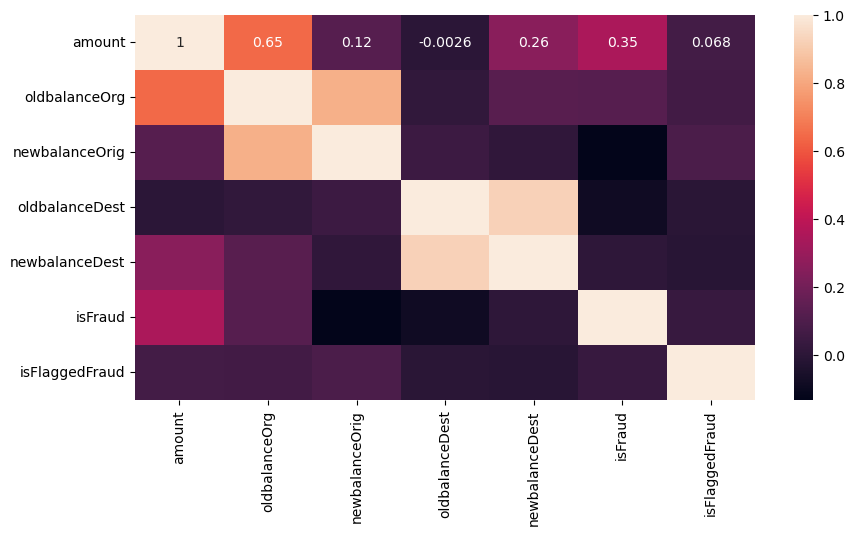

In [37]:
# Using Heatmap for better understanding

plt.figure(figsize=(10,5))
sns.heatmap(df_correlation.corr(),annot=True)

#### From this we can conclude that

1. oldbalanceOrg and newbalanceOrig are highly positively correlated. This suggests that one of each pair could potentially be redundant and might be removed depending on further analysis.
2. Similarly, oldbalanceDest and newbalanceDest are highly positively correlated. This suggests that one of each pair could potentially be redundant and might be removed depending on further analysis.
3. The isFraud and isFlaggedFraud features have very weak correlations with other variables, indicating that more complex interactions or additional features might be needed to accurately predict fraud.

In [38]:
df['type'].unique()

array(['PAYMENT', 'CASH_OUT', 'CASH_IN', 'TRANSFER', 'DEBIT'],
      dtype=object)

In [39]:
# mapping values (handling categorical feature)

category_mapping = {
    'PAYMENT': 0,
    'TRANSFER': 1,
    'CASH_OUT': 2,
    'DEBIT': 3,
    'CASH_IN': 4
}

df['transaction_type'] = df['type'].map(category_mapping)

<Axes: xlabel='type', ylabel='isFraud'>

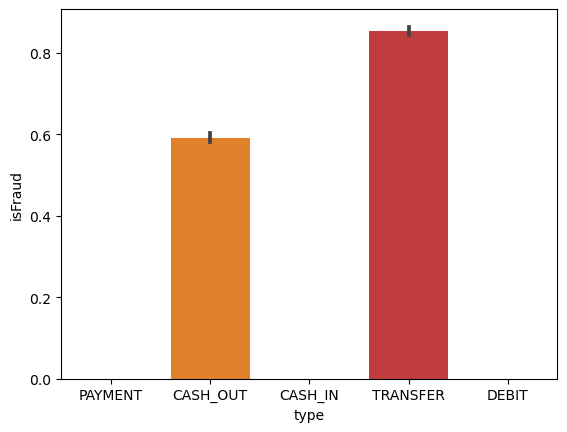

In [40]:
sns.barplot(x=df['type'],y=df['isFraud'])

#### This graph shows that the majority of fraudulent activities occur during TRANSFER transactions, making them the most common type of fraud. This is followed by CASH_OUT transactions

In [41]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transaction_type
5844077,PAYMENT,3646.13,20532.0,16885.87,0.00,0.00,0,0,0
6359076,CASH_OUT,150708.06,2562.0,0.00,544897.92,695605.98,0,0,2
5554125,PAYMENT,9738.36,0.0,0.00,0.00,0.00,0,0,0
6121974,PAYMENT,1533.54,49852.0,48318.46,0.00,0.00,0,0,0
2434094,PAYMENT,27865.80,0.0,0.00,0.00,0.00,0,0,0


<Axes: xlabel='amount'>

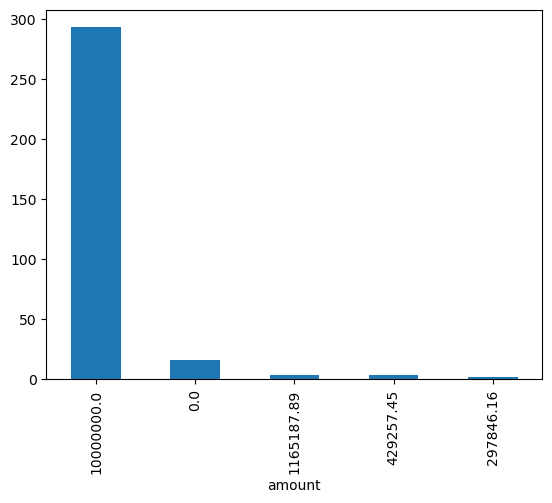

In [43]:
df['amount'].value_counts().sort_values(ascending = False).head().plot(kind = 'bar')

#### The most frequent transaction amount is 10,000,000 occurring more. This suggests that there may be a common transaction size or a default value used for certain types of transactions.

Text(0.5, 1.0, 'Count of each type of transaction')

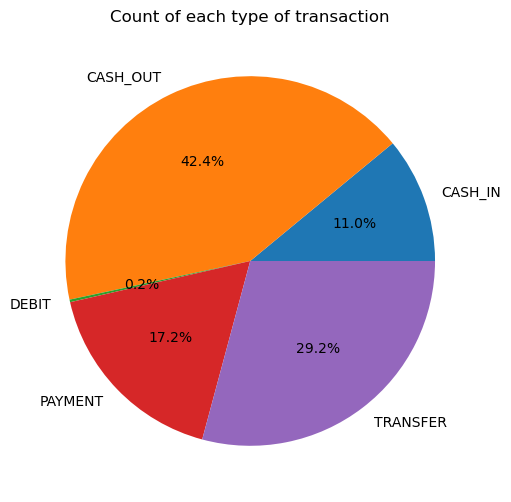

In [44]:
counts = df.groupby('type').count()['amount']
plt.figure(figsize = (6,6))
plt.pie(counts, labels = counts.index, autopct = "%1.1f%%")
plt.title('Count of each type of transaction')

1. CASH-OUT has the hight count, followed by CASH-IN and PAYMENT.
2. Analyzing the distribution of transaction types helps financial institutions assess risks and develop effective mitigation strategies.
3. A higher frequency of certain transaction types may necessitate stronger security protocols or increased monitoring to reduce the risk of fraud or financial loss.
4. Studying transaction types can reveal valuable insights into customer behavior and preferences, enabling the development of targeted marketing strategies and tailored product offerings.

In [45]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transaction_type
5844077,PAYMENT,3646.13,20532.0,16885.87,0.00,0.00,0,0,0
6359076,CASH_OUT,150708.06,2562.0,0.00,544897.92,695605.98,0,0,2
5554125,PAYMENT,9738.36,0.0,0.00,0.00,0.00,0,0,0
6121974,PAYMENT,1533.54,49852.0,48318.46,0.00,0.00,0,0,0
2434094,PAYMENT,27865.80,0.0,0.00,0.00,0.00,0,0,0


In [46]:
# Removing the columns that are not necessary for the data modeling
# isFlaggedFraud is not much correlated with any other variable
# the correlation value is high with newbalanceOrig of oldbalanceOrg
# the correlation value is high with newbalanceDest of oldbalanceDest
# We can drop one of the feature from both the columns but not removing for now as the dataset is already small now

df.drop(['isFlaggedFraud','type'], axis = 1, inplace = True)

In [47]:
# This is the final data that we are going to use to train the model

df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,transaction_type
5844077,3646.13,20532.0,16885.87,0.00,0.00,0,0
6359076,150708.06,2562.0,0.00,544897.92,695605.98,0,2
5554125,9738.36,0.0,0.00,0.00,0.00,0,0
6121974,1533.54,49852.0,48318.46,0.00,0.00,0,0
2434094,27865.80,0.0,0.00,0.00,0.00,0,0


In [72]:
#### If you want to check whether feature is guassian or normal distributed
#### Q-Q plot

def plot_data(df,feature):
    plt.figure(figsize=(6,5))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stats.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

In [73]:
# library for stats

import scipy.stats as stats
import pylab

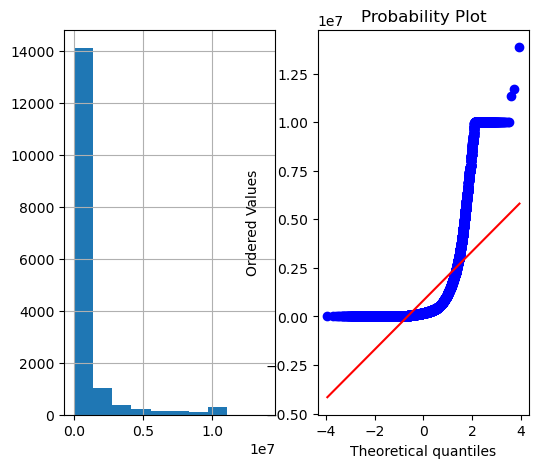

In [74]:
plot_data(df,'amount')

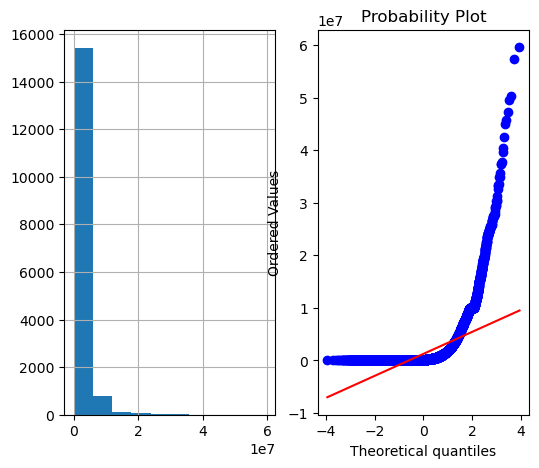

In [75]:
plot_data(df,'oldbalanceOrg')

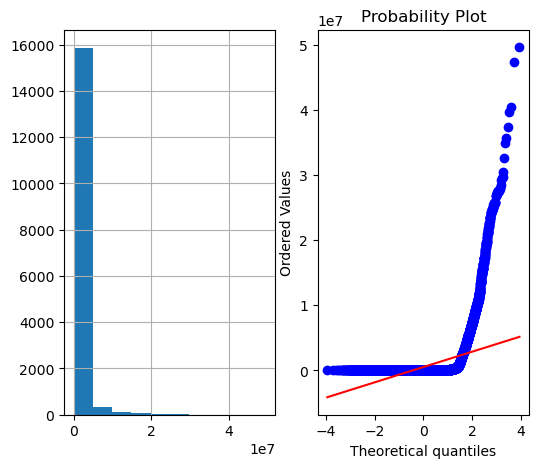

In [76]:
plot_data(df,'newbalanceOrig')

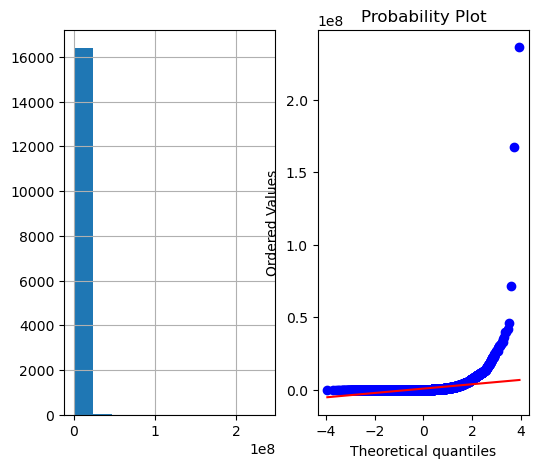

In [77]:
plot_data(df,'oldbalanceDest')

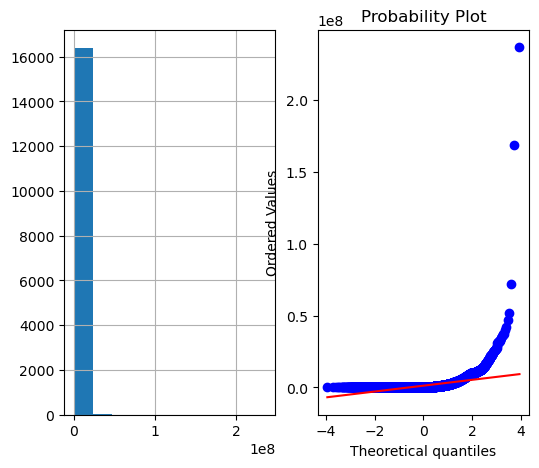

In [80]:
plot_data(df,'newbalanceDest')

#### Most of the data is right skewed so some algorithms may not give good accuracy (ex: linear regression)

In [79]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,transaction_type
5844077,3646.13,20532.0,16885.87,0.00,0.00,0,0
6359076,150708.06,2562.0,0.00,544897.92,695605.98,0,2
5554125,9738.36,0.0,0.00,0.00,0.00,0,0
6121974,1533.54,49852.0,48318.46,0.00,0.00,0,0
2434094,27865.80,0.0,0.00,0.00,0.00,0,0


In [49]:
# Independent features
X = df.drop(columns=['isFraud'])

# Dependent feature
y = df['isFraud']

print(X)
print(y)

             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
5844077     3646.13       20532.00        16885.87            0.00   
6359076   150708.06        2562.00            0.00       544897.92   
5554125     9738.36           0.00            0.00            0.00   
6121974     1533.54       49852.00        48318.46            0.00   
2434094    27865.80           0.00            0.00            0.00   
...             ...            ...             ...             ...   
6362615   339682.13      339682.13            0.00            0.00   
6362616  6311409.28     6311409.28            0.00            0.00   
6362617  6311409.28     6311409.28            0.00        68488.84   
6362618   850002.52      850002.52            0.00            0.00   
6362619   850002.52      850002.52            0.00      6510099.11   

         newbalanceDest  transaction_type  
5844077            0.00                 0  
6359076       695605.98                 2  
5554125            0.00    

In [81]:
print(X.shape)
print(y.shape)

(16426, 6)
(16426,)


In [82]:
# Train Test Split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [83]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13140, 6)
(3286, 6)
(13140,)
(3286,)


In [84]:
# Importing RandomForest Classifer for model training and GridSearchCV for hyperparameter tuning

from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

In [85]:
# Initializing the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

In [92]:
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [94]:
y_pred = rf.predict(X_test)

In [95]:
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Classifier Accuracy: 0.9917833231892879
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1643
           1       0.98      1.00      0.99      1643

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



### Questions and their answers from Task Details file

1. Data cleaning including missing values, outliers and multi-collinearity.
    * There were no missing values.
    * Outliers could be prevalent in financial data. The most common transaction amount being 10,000,000 may suggest outliers or default values used for transactions.
    * High correlation between oldbalanceOrg and newbalanceOrg, as well as oldbalanceDest and newbalanceDest, indicates potential multicollinearity. Though both features were kept for model training, removing one from each pair could simplify the model without significantly impacting performance.
  
2. Describe your fraud detection model in elaboration.
   * A Random Forest Classifier was employed due to its ability to handle imbalanced data and capture complex interactions between features.
   * Undersampling: Applied to address the class imbalance problem, reducing the majority class (isFraud=0) to a smaller, manageable size.
   * Feature Selection: Dropped non-predictive features like step, nameOrig, and nameDest.
   * Training and Evaluation: The model was trained on the undersampled data and evaluated using precision, recall, and F1-score.
  
3. How did you select variables to be included in the model?
   * Variables were chosen based on their potential predictive value.
   * The decision to keep correlated features (oldbalanceOrg, newbalanceOrig, etc.) was likely driven by their importance in capturing transaction patterns, even if they introduce multicollinearity.
  
4. Demonstrate the performance of the model by using best set of tools.
   * Accuracy: 99.18%, indicating the model's strong overall performance.
   * Precision and Recall: High precision (100% for isFraud=0, 98% for isFraud=1) and high recall (98% for isFraud=0, 100% for isFraud=1), demonstrating the model's ability to correctly identify both fraudulent and non-fraudulent transactions with minimal errors.
   * F1-Score: A balance between precision and recall, achieving 99% for both classes, making the model reliable and robust.
  
5. What are the key factors that predict fraudulent customer?
   * The amount of the transaction, especially when it’s significantly large (e.g., 10,000,000), seems to be a strong indicator of potential fraud.
   * Fraudulent transactions are most common in TRANSFER and CASH_OUT types, highlighting their vulnerability.

6. Do these factors make sense? If yes, How? If not, How not?
   * YES
   * Transaction Amount: Large or suspiciously consistent amounts are often flagged in fraud detection systems.
   * Transaction Type: Transfers and cash-outs are inherently risky due to their potential for quickly moving funds out of accounts.
   * Account Balances: The starting and ending balances give insight into whether a transaction is typical for a customer, aiding in fraud detection.
  
7. What kind of prevention should be adopted while company update its infrastructure?
   * Implement real-time monitoring for high-risk transaction types (TRANSFER, CASH_OUT), especially involving large amounts.
   * Introduce advanced anomaly detection techniques, possibly using machine learning models trained on normal transaction patterns.
   * Conduct regular audits to ensure compliance with security protocols and update them as needed.
  
8. Assuming these actions have been implemented, how would you determine if they work?
   * Compare pre- and post-implementation fraud rates. A significant reduction would indicate success.
   * Gather feedback from customers, particularly those who have experienced flagged transactions
   * Continuously reassess the model’s performance and adjust it based on evolving fraud patterns and transaction data.

### "My system is not very fast, so I was unable to perform hyperparameter tuning. Additionally, undersampling was necessary due to system limitations, but we still achieved good accuracy even with these constraints."